In [2]:
# Import pytorch
import torch
import torch.nn as nn
print(torch.__version__)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

2.2.2+cu121
Device: cuda


## 1. Data preparing and loading

In [7]:
# Create weight and bias
weight = 0.7
bias = 0.3

# Create X and y (features and values)
X = torch.arange(0, 1, 0.02).unsqueeze(dim=1)  # without unsqueeze, errors will happen later on (shapes within linear layers)
y = weight * X + bias
X.shape, y.shape

(torch.Size([50, 1]), torch.Size([50, 1]))

In [8]:
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [14]:
# Split the data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

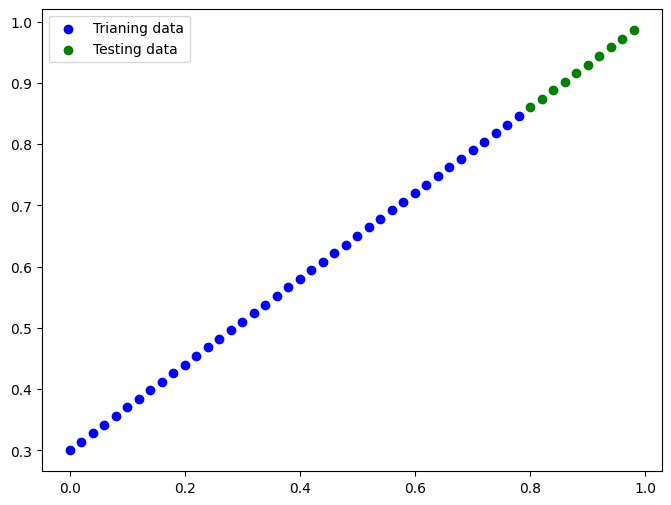

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# Plot the training data in blue
plt.scatter(X_train, y_train, c='b', label="Trianing data")
# Plot the testing data in green
plt.scatter(X_test, y_test, c='g', label="Testing data")

plt.legend()
plt.show()

## 2. Build the model

In [26]:
# Create a linear regression model
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(in_features=1,
                                     out_features=1)

    def forward(self, x):
        return self.linear_layer(x)

# Set the manual seed when creating the model
torch.manual_seed(42)
model = LinearRegressionModel().to(device)
model

LinearRegressionModel(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [27]:
model.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7645]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.8300], device='cuda:0'))])

In [28]:
# Check model device
next(model.parameters()).device

device(type='cuda', index=0)

## 3. Training

In [33]:
# Create loss function
loss_fn = nn.L1Loss()

# Create optimizer
optimizer = torch.optim.Adam(params=model.parameters(),  # optimize newly created model's parameters
                            lr=0.01)

In [35]:
#Train the model

torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data on the device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build a training loop
for epoch in range(epochs):
    ### Trining
    model.train()  # train mode is on by default after construction    
    
    # 1. Forward pass
    y_pred = model(X_train)
    
    # 2. Calculate loss
    loss = loss_fn(y_pred, y_train)
    
    # 3. Zero grad optimizer
    optimizer.zero_grad()
    
    # 4. Loss backward
    loss.backward()
    
    # 5. Step the optimizer
    optimizer.step()

    ### Testing
    model.eval()  # put the model in evaluation mode for testing (inference)
    # 1. Forward pass
    with torch.inference_mode():
        test_pred = model(X_test)
        
        # 2. Calculate loss
        test_loss = loss_fn(test_pred, y_test)
        
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Train loss: 0.0028789364732801914 | Test loss: 0.0038926363922655582
Epoch: 100 | Train loss: 0.003213830292224884 | Test loss: 0.003561299992725253
Epoch: 200 | Train loss: 0.00287402281537652 | Test loss: 0.0038867772091180086
Epoch: 300 | Train loss: 0.003210146678611636 | Test loss: 0.003557103918865323
Epoch: 400 | Train loss: 0.0028710595797747374 | Test loss: 0.003883457276970148
Epoch: 500 | Train loss: 0.0032070823945105076 | Test loss: 0.003553378628566861
Epoch: 600 | Train loss: 0.0028690004255622625 | Test loss: 0.0038811564445495605
Epoch: 700 | Train loss: 0.0032051026355475187 | Test loss: 0.0035510242450982332
Epoch: 800 | Train loss: 0.0028675056528300047 | Test loss: 0.003879499388858676
Epoch: 900 | Train loss: 0.0032035589683800936 | Test loss: 0.0035491406451910734


## 4. Predicting

In [49]:
# Make predictions

# Turn model into evaluation mode
model.eval()

# Make predictions on the test data
with torch.inference_mode():
    y_preds = model(X_test)

y_preds

tensor([[0.8640],
        [0.8781],
        [0.8921],
        [0.9062],
        [0.9203],
        [0.9343],
        [0.9484],
        [0.9624],
        [0.9765],
        [0.9905]], device='cuda:0')

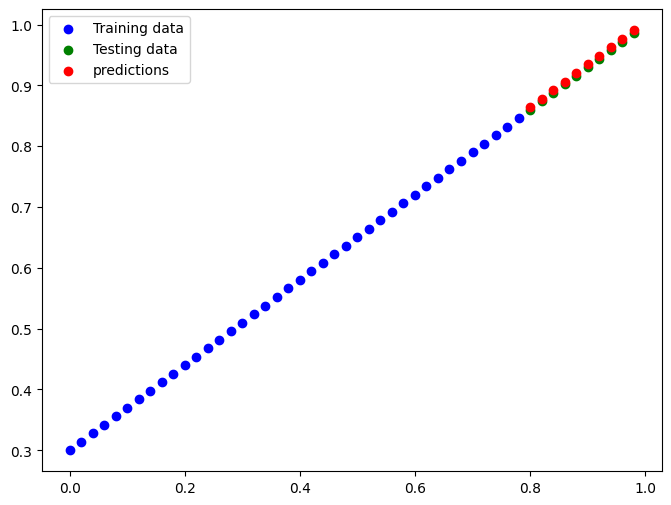

In [50]:
# Put data on the CPU and plot it

plt.figure(figsize=(8, 6))
plt.scatter(X_train.cpu(), y_train.cpu(), c='b', label='Training data')
plt.scatter(X_test.cpu(), y_test.cpu(), c='g', label='Testing data')
plt.scatter(X_test.cpu(), y_preds.cpu(), c='r', label='predictions')
plt.legend()
plt.show()

## 5. Saving and loading the model

In [51]:
# Create model save path
MODEL_SAVE_PATH = 'models/01_pytorch_workflow_model_1.pth'

# Save the model save path
torch.save(model.state_dict(),
          MODEL_SAVE_PATH)
print(f"Saving model to: {MODEL_SAVE_PATH}")

Saving model to: models/01_pytorch_workflow_model_1.pth


In [52]:
# Load the model
MODEL_SAVE_PATH = 'models/01_pytorch_workflow_model_1.pth'
loaded_model = LinearRegressionModel().to(device)

loaded_model.load_state_dict(torch.load(MODEL_SAVE_PATH))
loaded_model.to(device)

print(f"Loaded model:\n{loaded_model}")
print(f"Model on device:\n{next(loaded_model.parameters()).device}")

Loaded model:
LinearRegressionModel(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)
Model on device:
cuda:0


In [53]:
# Evaluate loaded model
loaded_model.eval()
with torch.inference_mode():
    loadeded_model_preds = loaded_model(X_test)
y_preds == loadeded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')